# Hexokinase (HEX1)

For the construction of the HEX1 `EnzymeModule`, the following assumptions were made:

1. The enzyme is a monomer.
2. The enzyme binding and catalyzation of substrates occurs in an random sequential mechanism.
3. The enzyme experiences product inhibtion, and is competitively inhibited by 23DPG when complexed with D-glucose.

\\(\text{[HEX1]}_{total} = 24 nM = 0.024 \mu M = 0.000024 mM\\).

Based on “Network-Level Allosteric Effects Are Elucidated by Detailing How Ligand-Binding Events Modulate Utilization of Catalytic Potentials."

__URL:__ https://doi.org/10.1371/journal.pcbi.1006356

In [1]:
from operator import attrgetter
from os import path

from cobra import DictList

import matplotlib.pyplot as plt

from scipy import optimize

import sympy as sym

import mass
from mass import MassMetabolite, Simulation, UnitDefinition
from mass.enzyme_modules import EnzymeModule
from mass.io import json
from mass.util import strip_time, qcqa_model

print("MASSpy version: " + mass.__version__)

MASSpy version: 0.1.0


## Load Models

In [2]:
# Load the glycolysis model and hemoglobin model
glycolysis = json.load_json_model(
    filename=path.realpath(path.join("CS1_data", "models", "Glycolysis.json")))
hemoglobin = json.load_json_model(
    filename=path.realpath(path.join("CS1_data", "models", "Hemoglobin.json")))
glycolysis_hb = glycolysis.merge(hemoglobin, inplace=False)

Using license file /Users/zhaiman/opt/licenses/gurobi.lic
Academic license - for non-commercial use only
Read LP format model from file /var/folders/36/g2np3l0d6t9dyr4rk3tvc8f80000gn/T/tmp6gnt5n2z.lp
Reading time = 0.00 seconds
: 20 rows, 44 columns, 122 nonzeros


## Module Construction

In [3]:
HEX1 = EnzymeModule("HEX1", name="Hexokinase (D-glucose:ATP)",
                    subsystem="Glycolysis")

### Metabolites
#### Ligands

In [4]:
glc__D_c = MassMetabolite(
    "glc__D_c",
    name="D-Glucose",
    formula="C6H12O6",
    charge=0,
    compartment="c")
g6p_c = MassMetabolite(
    "g6p_c",
    name="D-Glucose 6-phosphate",
    formula="C6H11O9P",
    charge=-2,
    compartment="c")
atp_c = MassMetabolite(
    "atp_c",
    name="ATP",
    formula="C10H12N5O13P3",
    charge=-4,
    compartment="c")
adp_c = MassMetabolite(
    "adp_c",
    name="ADP",
    formula="C10H12N5O10P2",
    charge=-3,
    compartment="c")
_23dpg_c = MassMetabolite(
    "_23dpg_c", 
    name="2,3-Disphospho-D-glycerate", 
    formula="C3H3O10P2",
    charge=-5,
    compartment="c")
h_c = MassMetabolite(
    "h_c",
    name="H+",
    formula="H",
    charge=1,
    compartment="c")

HEX1.add_metabolites([glc__D_c, g6p_c, atp_c, adp_c, _23dpg_c, h_c])

HEX1.enzyme_module_ligands_categorized =  {
    "substrates": glc__D_c,
    "cofactors": atp_c,
    "inhibitors": _23dpg_c,
    "products": [adp_c, g6p_c, h_c]}

for group in HEX1.enzyme_module_ligands_categorized:
    print("{0}: {1}".format(
        group.id, str(sorted([m.id for m in group.members]))))

substrates: ['glc__D_c']
cofactors: ['atp_c']
inhibitors: ['_23dpg_c']
products: ['adp_c', 'g6p_c', 'h_c']


#### EnzymeModuleForms

In [5]:
HEX1.make_enzyme_module_form(
    "hex1_c",
    name="Automatic",
    categories="Active",
    compartment="c");

HEX1.make_enzyme_module_form(
    "hex1_A_c",
    name="Automatic",
    categories="Active",
    bound_metabolites={atp_c: 1},
    compartment="c");

HEX1.make_enzyme_module_form(
    "hex1_G_c",
    name="Automatic",
    categories="Active",
    bound_metabolites={glc__D_c: 1},
    compartment="c");

HEX1.make_enzyme_module_form(
    "hex1_AG_c",
    name="Automatic",
    categories="Active",
    bound_metabolites={glc__D_c: 1, atp_c: 1},
    compartment="c");

HEX1.make_enzyme_module_form(
    "hex1_G_CI_c",
    name="Automatic",
    categories="Inhibited",
    bound_metabolites={glc__D_c: 1, _23dpg_c: 1},
    compartment="c");

HEX1.make_enzyme_module_form(
    "hex1_A_PI_c",
    name="Automatic",
    categories="Inhibited",
    bound_metabolites={adp_c: 1},
    compartment="c");

HEX1.make_enzyme_module_form(
    "hex1_G_PI_c",
    name="Automatic",
    categories="Inhibited",
    bound_metabolites={g6p_c: 1},
    compartment="c");

for group in HEX1.enzyme_module_forms_categorized:
    print("{0}: {1}\n".format(
        group.id, str(sorted([m.id for m in group.members]))))

Active: ['hex1_AG_c', 'hex1_A_c', 'hex1_G_c', 'hex1_c']

Inhibited: ['hex1_A_PI_c', 'hex1_G_CI_c', 'hex1_G_PI_c']



### Reactions
#### EnzymeModuleReactions

In [6]:
HEX1.make_enzyme_module_reaction(
    "HEX1_1",
    name="Automatic",
    subsystem="Glycolysis",
    reversible=True,
    categories="product_inhibition",
    metabolites_to_add={
        "hex1_c": -1,
        "adp_c": -1,
        "hex1_A_PI_c": 1});

HEX1.make_enzyme_module_reaction(
    "HEX1_2",
    name="Automatic",
    subsystem="Glycolysis",
    reversible=True,
    categories="product_inhibition",
    metabolites_to_add={
        "hex1_c": -1,
        "g6p_c": -1,
        "hex1_G_PI_c": 1});

HEX1.make_enzyme_module_reaction(
    "HEX1_3",
    name="Automatic",
    subsystem="Glycolysis",
    reversible=True,
    categories="glc__D_c_binding",
    metabolites_to_add={
        "hex1_c": -1,
        "glc__D_c": -1,
        "hex1_G_c": 1});

HEX1.make_enzyme_module_reaction(
    "HEX1_4",
    name="Automatic",
    subsystem="Glycolysis",
    reversible=True,
    categories="atp_c_binding",
    metabolites_to_add={
        "hex1_c": -1,
        "atp_c": -1,
        "hex1_A_c": 1});

HEX1.make_enzyme_module_reaction(
    "HEX1_5",
    name="Automatic",
    subsystem="Glycolysis",
    reversible=True,
    categories="competitive_inhibition",
    metabolites_to_add={
        "hex1_G_c": -1,
        "_23dpg_c": -1,
        "hex1_G_CI_c": 1});

HEX1.make_enzyme_module_reaction(
    "HEX1_6",
    name="Automatic",
    subsystem="Glycolysis",
    reversible=True,
    categories="atp_c_binding",
    metabolites_to_add={
        "hex1_G_c": -1,
        "atp_c": -1,
        "hex1_AG_c": 1});

HEX1.make_enzyme_module_reaction(
    "HEX1_7",
    name="Automatic",
    subsystem="Glycolysis",
    reversible=True,
    categories="glc__D_c_binding",
    metabolites_to_add={
        "hex1_A_c": -1,
        "glc__D_c": -1,
        "hex1_AG_c": 1});

HEX1.make_enzyme_module_reaction(
    "HEX1_8",
    name="Automatic",
    subsystem="Glycolysis",
    reversible=True,
    categories="catalyzation",
    metabolites_to_add={
        "hex1_AG_c": -1,
        "hex1_c": 1,
        "adp_c": 1,
        "g6p_c": 1,
        "h_c": 1});

# Access categorized attribute for enzyme module reactions and print
for group in HEX1.enzyme_module_reactions_categorized:
    print("{0}: {1}\n".format(
        group.id, str(sorted([m.id for m in group.members]))))

product_inhibition: ['HEX1_1', 'HEX1_2']

glc__D_c_binding: ['HEX1_3', 'HEX1_7']

atp_c_binding: ['HEX1_4', 'HEX1_6']

competitive_inhibition: ['HEX1_5']

catalyzation: ['HEX1_8']



#### Unify Rate Parameters

In [7]:
abbreviations = ["A", "G"]
ligands = [atp_c, glc__D_c]

for met, unified_id in zip(ligands, abbreviations):
    group = HEX1.enzyme_module_reactions_categorized.get_by_id(
        "_".join((met.id, "binding")))
    reactions = sorted(group.members, key=attrgetter("id"))
    HEX1.unify_rate_parameters(
        reactions, unified_id, rate_type=1,
        enzyme_prefix=True)

HEX1.unify_rate_parameters(
    HEX1.enzyme_module_reactions_categorized.get_by_id("catalyzation").members,
    "HEX1")

# Access categorized attribute for enzyme module reactions and print
for group in HEX1.enzyme_module_reactions_categorized:
    header = "Category: " + group.id
    print("\n" + header + "\n" + "-" * len(header))
    for reaction in sorted(group.members, key=attrgetter("id")):
        print(reaction.id + ": " + str(reaction.rate))


Category: product_inhibition
----------------------------
HEX1_1: kf_HEX1_1*(adp_c(t)*hex1_c(t) - hex1_A_PI_c(t)/Keq_HEX1_1)
HEX1_2: kf_HEX1_2*(g6p_c(t)*hex1_c(t) - hex1_G_PI_c(t)/Keq_HEX1_2)

Category: glc__D_c_binding
--------------------------
HEX1_3: kf_HEX1_G*(glc__D_c(t)*hex1_c(t) - hex1_G_c(t)/Keq_HEX1_G)
HEX1_7: kf_HEX1_G*(glc__D_c(t)*hex1_A_c(t) - hex1_AG_c(t)/Keq_HEX1_G)

Category: atp_c_binding
-----------------------
HEX1_4: kf_HEX1_A*(atp_c(t)*hex1_c(t) - hex1_A_c(t)/Keq_HEX1_A)
HEX1_6: kf_HEX1_A*(atp_c(t)*hex1_G_c(t) - hex1_AG_c(t)/Keq_HEX1_A)

Category: competitive_inhibition
--------------------------------
HEX1_5: kf_HEX1_5*(_23dpg_c(t)*hex1_G_c(t) - hex1_G_CI_c(t)/Keq_HEX1_5)

Category: catalyzation
----------------------
HEX1_8: kf_HEX1*(hex1_AG_c(t) - adp_c(t)*g6p_c(t)*hex1_c(t)/Keq_HEX1)


### Compartments

In [8]:
HEX1.compartments = {"c": "Cytosol"}

## Steady State Concentrations and Rate Constants
### Rate Equation

In [9]:
catalyzation_rxns = HEX1.enzyme_module_reactions_categorized.get_by_id(
    "catalyzation").members
HEX1.make_enzyme_rate_equation(
    catalyzation_rxns,
    use_rates=True, update_enzyme=True)

print(HEX1.enzyme_rate_equation)

kf_HEX1*(Keq_HEX1*hex1_AG_c(t) - adp_c(t)*g6p_c(t)*hex1_c(t))/Keq_HEX1


### Solve steady state concentrations symbolically

In [10]:
ode_dict = {
    sym.Symbol(enzyme_module_form.id): sym.Eq(strip_time(enzyme_module_form.ode), 0)
    for enzyme_module_form in HEX1.enzyme_module_forms}

# Get enzyme module forms
enzyme_module_forms = HEX1.enzyme_module_forms.copy()
# Reverse list for increased performance (due to symmetry assumption)
# by solving for the most activated/inhibitors bound first.
enzyme_module_forms.reverse()

enzyme_solutions = {}
for enzyme_module_form in enzyme_module_forms:
    # Skip dependent variable
    if "hex1_c" == str(enzyme_module_form):
        continue
    enzyme_module_form = sym.Symbol(enzyme_module_form.id)
    # Susbtitute in previous solutions and solve for the enzyme module form, 
    equation = ode_dict[enzyme_module_form]
    sol = sym.solveset(equation.subs(enzyme_solutions),
                       enzyme_module_form)
    enzyme_solutions[enzyme_module_form] = list(sol)[0]
    # Update the dictionary of solutions with the solutions
    enzyme_solutions.update({
        enzyme_module_form: sol.subs(enzyme_solutions) 
        for enzyme_module_form, sol in enzyme_solutions.items()})
    
enzyme_rate_equation = strip_time(HEX1.enzyme_rate_error(False))

# Solve for last unknown concentration symbolically
sol = sym.solveset(enzyme_rate_equation.subs(enzyme_solutions),
                   "hex1_c")

# Update solution dictionary with the new solution
enzyme_solutions[sym.Symbol("hex1_c")] = list(sol)[0]

# Update solutions with free variable solutions
enzyme_solutions = {
    enzyme_module_form: sym.simplify(solution.subs(enzyme_solutions))
    for enzyme_module_form, solution in enzyme_solutions.items()}

#### Numerical Values

In [11]:
numerical_values = {}

# Get ligand IDs and parameter IDs
ligand_ids = sorted([str(ligand) for ligand in HEX1.enzyme_module_ligands])
parameter_ids = ["_".join((HEX1.id, abbrev)) for abbrev in abbreviations]
parameter_ids.extend([HEX1.id])

# Get the steady state flux value and add to numerical values
HEX1.enzyme_rate = glycolysis_hb.reactions.get_by_id(HEX1.id).steady_state_flux
numerical_values.update({HEX1.enzyme_flux_symbol_str: HEX1.enzyme_rate})

# Get the steady state concentration values and add to numerical values
initial_conditions = {
    str(ligand): glycolysis_hb.initial_conditions[glycolysis_hb.metabolites.get_by_id(ligand)]
    for ligand in ligand_ids}
numerical_values.update(initial_conditions)

# Define parameter values and add to numerical values
# Because of the QEA, invert dissociation constants for Keq
parameter_values = {
    "Keq_" + parameter_id: value 
    for parameter_id, value in zip(parameter_ids, [1/2.06, 1/0.038, 4000/((1/2.06) * (1/0.038))])}

for reaction, value in zip(["HEX1_1", "HEX1_2", "HEX1_5"], [1, 0.015, 1/5.5]):
    reaction = HEX1.reactions.get_by_id(reaction)
    parameter_values[reaction.Keq_str] = value
numerical_values.update(parameter_values)

# Display numerical values
print("\nNumerical Values\n----------------")
for k, v in numerical_values.items():
    print("{0} = {1}".format(k, v))


Numerical Values
----------------
v_HEX1 = 1.12
_23dpg_c = 3.1
adp_c = 0.28999999119642894
atp_c = 1.6
g6p_c = 0.04859997822195344
glc__D_c = 1.0000003633303347
h_c = 8.997571410461636e-05
Keq_HEX1_A = 0.4854368932038835
Keq_HEX1_G = 26.315789473684212
Keq_HEX1 = 313.11999999999995
Keq_HEX1_1 = 1
Keq_HEX1_2 = 0.015
Keq_HEX1_5 = 0.18181818181818182


### Calculate Steady State Concentrations

#### Set total enzyme concentration

In [12]:
HEX1.enzyme_concentration_total = 24e-6

#### Determine rate constants

In [13]:
# Substitute values into equations
enzyme_solutions = {
    enzyme_module_form: sym.simplify(solution.subs(numerical_values))
    for enzyme_module_form, solution in enzyme_solutions.items()}

args = set()
for sol in enzyme_solutions.values():
    args.update(sol.atoms(sym.Symbol))

enzyme_total_constraint = abs(
    strip_time(HEX1.enzyme_concentration_total_error(use_values=False)))

# Substitute value for enzyme concentration total
enzyme_total_constraint = enzyme_total_constraint.subs({
    HEX1.enzyme_total_symbol_str: HEX1.enzyme_concentration_total})
# Substitute solutions into constraint and simplify
enzyme_total_constraint = sym.simplify(
    enzyme_total_constraint.subs(enzyme_solutions))

# Create a sorted tuple of the arguments to ensure the input format does not change
args = tuple(sorted([str(arg) for arg in list(args)]))
# Create the objective function as a lambda function
objective_function = lambda x: sym.lambdify(args, enzyme_total_constraint)(*x)

# Set arguments for minimization 
initial_guess = [1e8, 9376585, 52001]
kf_bounds = ((1e3, 1e9), (1e3, 1e9), (1e3, 1e9))
constraints = (
    {"type": "eq", "fun": objective_function})
# Find a feasible solution
sol = optimize.minimize(
    objective_function, x0=initial_guess, method="trust-constr",
    bounds=kf_bounds,
    options={"gtol": 1e-12, "xtol": 1e-12, "maxiter": 1e4, "disp": True})

# Check whether optimzation was successful
print("\nOptimization Success: {0}".format(sol.success))
if sol.success:
    # Update the paramter values dictionary with the feasible solution
    parameter_values.update(
        dict(zip(args, [round(x) for x in sol.x])))
    print("Optimization Optimality: {0:.4e}".format(sol.optimality))
    print("Parameter Solutions: {:}".format(str({
        arg: parameter_values[arg] for arg in args})))
    # Plug solutions back into constraints for validation
    print("Concentration Error: {0:.4e}".format(
        enzyme_total_constraint.subs(parameter_values)))

`xtol` termination condition is satisfied.
Number of iterations: 88, function evaluations: 280, CG iterations: 81, optimality: 4.31e-10, constraint violation: 0.00e+00, execution time:  5.4 s.

Optimization Success: True
Optimization Optimality: 4.3097e-10
Parameter Solutions: {'kf_HEX1': 100000000, 'kf_HEX1_A': 9376585, 'kf_HEX1_G': 54549}
Concentration Error: 1.3233e-11


#### Set initial conditions

In [14]:
parameter_values.update({
    "kf_" + rxn: 1e6 for rxn in ["HEX1_1", "HEX1_2", "HEX1_5"]})

initial_conditions.update({
    str(enzyme_module_form): float(sym.simplify(solution.subs(parameter_values)))
    for enzyme_module_form, solution in enzyme_solutions.items()})

# Set initial conditions
for met, concentration in initial_conditions.items():
    HEX1.metabolites.get_by_id(str(met)).ic = concentration
    
for header, dictlist in zip(["Ligand", "\nEnzyme"],
                            [HEX1.enzyme_module_ligands, HEX1.enzyme_module_forms]):
    header += " Concentrations"
    print("\n".join([header, "-" * len(header)]))
    for forms in dictlist:
        ic = initial_conditions[forms.id]
        print("{0} = {1}".format(forms.id, ic))

Ligand Concentrations
---------------------
glc__D_c = 1.0000003633303347
g6p_c = 0.04859997822195344
atp_c = 1.6
adp_c = 0.28999999119642894
_23dpg_c = 3.1
h_c = 8.997571410461636e-05

Enzyme Concentrations
----------------------
hex1_c = 1.1571975997530738e-05
hex1_A_c = 8.962632702595526e-06
hex1_G_c = 5.7158274551285884e-08
hex1_AG_c = 1.172087171587165e-08
hex1_G_CI_c = 3.221648201981567e-08
hex1_A_PI_c = 3.3558729374092007e-06
hex1_G_PI_c = 8.435966721974423e-09


### Set Parameters

In [15]:
# Update based on publication values
parameter_values.update({
    'kf_HEX1': 100000000.0,
    'kf_HEX1_A': 9376585.0,
    'kf_HEX1_G': 52001.0})

# Add the custom parameters and values for kf and Keq to module
HEX1.custom_parameters.update(parameter_values)
# Assign parameter values for reactions that do not use custom parameters
for reaction in HEX1.reactions:
    if reaction not in HEX1.custom_rates:
        reaction.kf = HEX1.custom_parameters.pop(reaction.kf_str)
        reaction.Keq = HEX1.custom_parameters.pop(reaction.Keq_str)

### Units

In [16]:
concentration = UnitDefinition("mM", name="Millimolar", list_of_units=["millimole", "per_litre"])
time = UnitDefinition("hr", name="hour", list_of_units=["hour"])

HEX1.add_units([concentration, time])

## QC model

In [17]:
qcqa_model(HEX1, parameters=True, concentrations=True, 
           fluxes=False, superfluous=True, elemental=True)

╒══════════════════════════════════════════╕
│ MODEL ID: HEX1                           │
│ SIMULATABLE: True                        │
│ PARAMETERS NUMERICALY CONSISTENT: True   │
╞══════════════════════════════════════════╡
╘══════════════════════════════════════════╛


#### Errors

In [18]:
print("Concentration Absolute Error: {0:.4e}".format(
    abs(HEX1.enzyme_concentration_total_error(use_values=True))))

Concentration Absolute Error: 1.3233e-11


### Ordering of internal forms and reactions

In [19]:
new_metabolite_order = [
    "glc__D_c","g6p_c", "_23dpg_c", "atp_c", "adp_c", "h_c", 
    "hex1_c", "hex1_A_c", "hex1_G_c","hex1_AG_c", "hex1_G_CI_c", 
    "hex1_A_PI_c", "hex1_G_PI_c"]

if len(HEX1.metabolites) == len(new_metabolite_order):
    HEX1.metabolites = DictList(
        HEX1.metabolites.get_by_any(new_metabolite_order))
    
new_reaction_order = [
    "HEX1_1", "HEX1_2", "HEX1_3", "HEX1_4",
    "HEX1_5", "HEX1_6", "HEX1_7", "HEX1_8"]

if len(HEX1.reactions) == len(new_reaction_order):
    HEX1.reactions = DictList(
        HEX1.reactions.get_by_any(new_reaction_order))

## Simulation
### Merge model

In [20]:
# Merge the EnzymeModule into the MassModel
glycolysis_hb_HEX1 = glycolysis_hb.merge(HEX1, inplace=False)
# Remove the HEX1 MassReaction
glycolysis_hb_HEX1.remove_reactions([
    glycolysis_hb_HEX1.reactions.get_by_id("HEX1")])

Read LP format model from file /var/folders/36/g2np3l0d6t9dyr4rk3tvc8f80000gn/T/tmphbpa_xaf.lp
Reading time = 0.00 seconds
: 28 rows, 60 columns, 168 nonzeros


### Simulate

Successfully loaded MassModel 'Glycolysis_Hemoglobin_HEX1' into RoadRunner.


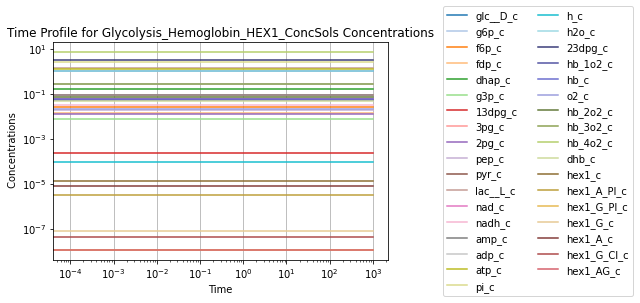

In [21]:
# Setup simulation object, ensure model is at steady state
sim = Simulation(glycolysis_hb_HEX1, verbose=True)

sim.find_steady_state(glycolysis_hb_HEX1, strategy="simulate",
                      update_values=True, tfinal=1e4)
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol, flux_sol = sim.simulate(glycolysis_hb_HEX1,
                                  time=(0, 1e3, 1e4 + 1))
# Quickly render and display time profiles 
conc_sol.view_time_profile()

## Export

In [22]:
json.save_json_model(
    mass_model=HEX1,
    filename=path.realpath(path.join("CS1_data", "models",  HEX1.id + ".json")))